In [1]:
from datasets import load_dataset
import torch 

ds = load_dataset("clip-benchmark/wds_flickr8k")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [11]:
import torch

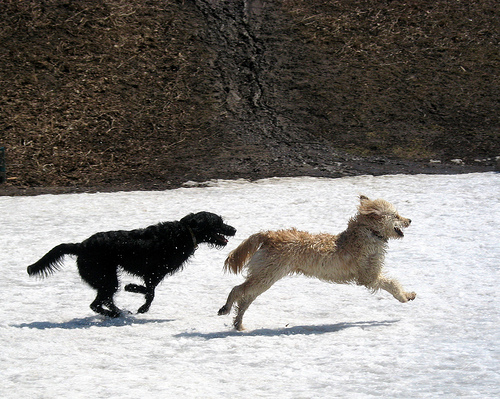

In [16]:
ds['train'][0]['jpg']

In [28]:
# load CLIP model
from transformers import CLIPModel, AutoProcessor, AutoTokenizer
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
clip_tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

C:\Users\mtnbt\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mtnbt\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# index all image to torch matrix, to prepare for image-retrieval; use CLIP's transformation
batch_size = 3  #TODO 128
image_tensors = []
for i in range(0, len(ds["train"]), batch_size):
    batch = ds["train"][i:i+batch_size]
    inputs = clip_processor(images=batch['jpg'], return_tensors="pt")
    image_tensors.append(clip_model.get_image_features(**inputs))
    break

image_tensors = torch.stack(image_tensors)

image_tensors.shape

### Retrieve with CLIP

In [ ]:
texts = ["a photo of a cat", "a photo of a dog"]
inputs = clip_tokenizer(texts, padding=True, return_tensors="pt")
text_features = clip_model.get_text_features(**inputs)

# retrieve images and show 
image_features = image_tensors
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)
similarity = (image_features @ text_features.T).softmax(dim=-1)

# show top-3 retrieved images
import matplotlib.pyplot as plt

for i, text in enumerate(texts):
    plt.figure(figsize=(10, 5))
    plt.title(f"Text: {text}")
    for j in similarity[i].argsort(descending=True).tolist()[:3]:
        plt.imshow(clip_processor.post_process(ds['train'][j]['jpg']))
        plt.axis('off')
        plt.show()

### Retrieve with Aligned Model

In [ ]:
from src.models import initialize_aligner_model

# Load aligned model
trained_aligner_dir = "../out/clip-to-minilm--linear"

import json
import os
with open(os.path.join(trained_aligner_dir, "metadata.json"), "r") as f:
    metadata = json.load(f)


# Load the embedding model (to invert)
from src.dataset.create_emb_dataset import get_text_enc_function
embed_func = get_text_enc_function(metadata['dataset_metadata']['source_emb_model_name'])

# Load trained aligner:
aligner_model = initialize_aligner_model(**metadata['model_kwargs'])
aligner_model.load_state_dict(torch.load(os.path.join(trained_aligner_dir, "best_model.pt"),
                                         map_location=torch.device('cuda')))
aligner_model.eval()
aligner_model.cuda()
